In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io

In [2]:


'''
Returns the sum of 2 vectors of not necesseraly the same length by appending 0's to the shorter vector.
'''
def sum_two_vec_pad(a, b):
    if len(a) < len(b):
        c = b.copy()
        c[:len(a)] += a
    else:
        c = a.copy()
        c[:len(b)] += b
    return c

'''
returns the energy for an estimated weight vector omega, with data (X, Y)
'''
def energy(w, X, Y):
    Y_est = np.sign(np.dot(X, w))
    return 0.5 * np.sum((Y - Y_est)**2)

def accept_prob(wp, w, beta, X, Y):
    return min(1, np.exp(-beta*(energy(wp, X, Y) - energy(w, X, Y))))

def accept_prob_with_energy(wp, w, beta, X, Y):
    next_energy = energy(wp, X, Y)
    return (min(1, np.exp(-beta*(next_energy - energy(w, X, Y)))), next_energy)

def accept_prob_with_energy_using_energy(wp, prev_energy, beta, X, Y):
    next_energy = energy(wp, X, Y)
    return (min(1.0, np.exp(-beta*(next_energy - prev_energy))), next_energy)

def overlap(wp, w):
    return 1.0 / (w.shape[0]) * np.dot(w, wp)

def delta_energy_fast(w, wp, idx, X, Y):
    Xw = np.dot(X, w)
    w_tmp = np.zeros(w.shape[0])
    w_tmp[idx] = wp[idx] - w[idx]
    Xwp = Xw + np.dot(X, w_tmp)
    Y_est = np.sign(Xw)
    Y_estp = np.sign(Xwp)
    return 0.5 * np.sum((Y - Y_estp)**2),  0.5*np.sum((Y - Y_est)**2)

def accept_prob_fast(wp, w, beta, X, Y, idx):
    e_next, e = delta_energy_fast(w, wp, idx, X, Y)
    return min(1, np.exp(-beta*(e_next - e))), e_next


In [25]:
def metropolis_fastest(nb_iter, w_init, beta, beta_pace, X, Y, epsilon=0):

    N = w_init.shape[0]
    w = np.copy(w_init)

    energy_record = np.array([])
    current_energy = energy(w, X, Y)
    energy_record = np.append(energy_record, current_energy)
    ctr = 0
    while (current_energy > epsilon and ctr < nb_iter):
        ctr += 1
        index_rand = np.random.randint(0, N)
        wp = np.copy(w)
        wp[index_rand] = -1 * wp[index_rand]
        
        accept_probability, next_energy = accept_prob_with_energy_using_energy(wp, current_energy, beta, X, Y)
        if np.random.uniform() < accept_probability:
            # accept the move, update the weights and the current energy
            w = wp 
            current_energy = next_energy
        
        energy_record= np.append(energy_record, current_energy)
        beta = beta * beta_pace
        
    return w, energy_record

def metropolis_mult_fastest(nb_iter, nb_runs, beta, beta_pace, N, M, X, Y, epsilon=0):
    energy_record_acc = np.zeros(N)

    for k in range(0, nb_runs):
        w_init =  2 * np.random.randint(0, 2, N) - 1
        _, energy_record = metropolis_fastest(nb_iter, w_init, beta, beta_pace, X, Y, epsilon)
        energy_record_acc = sum_two_vec_pad(energy_record_acc, energy_record)
        

    return energy_record_acc / nb_runs

In [32]:
# Import .mat files

file_name = 'competition/randomData.mat'
var = scipy.io.loadmat(file_name)

y = var['y']
X = var['X']
M = int(var['M'])
N = int(var['N'])
M_test = int(var['M_test'])
X_test = var['X_test']

beta = 0.3
beta_pace = 1.001
nb_iter = 10000
nb_runs = 1

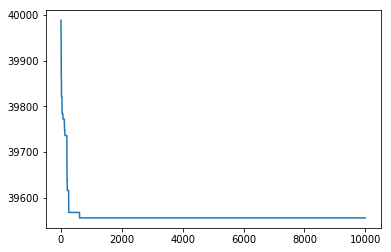

In [33]:
e_records = metropolis_mult_fastest(nb_iter, nb_runs, beta, beta_pace, N, M, X, y, epsilon=0);
plt.plot(e_records)